In [1]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange #pip install einops
from typing import List
import random
import math
from torchvision import datasets, transforms
from torch.utils.data import DataLoader 
from timm.utils import ModelEmaV3 #pip install timm 
from tqdm import tqdm #pip install tqdm
import matplotlib.pyplot as plt #pip install matplotlib
import torch.optim as optim
import numpy as np

/Users/yagmurseda/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:

class SinusoidalEmbeddings(nn.Module):
    def __init__(self, time_steps:int, embed_dim: int):
        super().__init__()
        position = torch.arange(time_steps).unsqueeze(1).float()
        div = torch.exp(torch.arange(0, embed_dim, 2).float() * -(math.log(10000.0) / embed_dim))
        embeddings = torch.zeros(time_steps, embed_dim, requires_grad=False)
        embeddings[:, 0::2] = torch.sin(position * div)
        embeddings[:, 1::2] = torch.cos(position * div)
        self.embeddings = embeddings

    def forward(self, x, t):
        embeds = self.embeddings[t].to(x.device)
        return embeds[:, :, None, None]

In [3]:
# Residual Blocks
class ResBlock(nn.Module):
    def __init__(self, C: int, num_groups: int, dropout_prob: float):
        super().__init__()
        self.relu = nn.ReLU(inplace=True)
        self.gnorm1 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.gnorm2 = nn.GroupNorm(num_groups=num_groups, num_channels=C)
        self.conv1 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(C, C, kernel_size=3, padding=1)
        self.dropout = nn.Dropout(p=dropout_prob, inplace=True)

    def forward(self, x, embeddings):
        x = x + embeddings[:, :x.shape[1], :, :]
        r = self.conv1(self.relu(self.gnorm1(x)))
        r = self.dropout(r)
        r = self.conv2(self.relu(self.gnorm2(r)))
        return r + x

In [4]:
class Attention(nn.Module):
    def __init__(self, C: int, num_heads:int , dropout_prob: float):
        super().__init__()
        self.proj1 = nn.Linear(C, C*3)
        self.proj2 = nn.Linear(C, C)
        self.num_heads = num_heads
        self.dropout_prob = dropout_prob

    def forward(self, x):
        h, w = x.shape[2:]
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.proj1(x)
        x = rearrange(x, 'b L (C H K) -> K b H L C', K=3, H=self.num_heads)
        q,k,v = x[0], x[1], x[2]
        x = F.scaled_dot_product_attention(q,k,v, is_causal=False, dropout_p=self.dropout_prob)
        x = rearrange(x, 'b H (h w) C -> b h w (C H)', h=h, w=w)
        x = self.proj2(x)
        return rearrange(x, 'b h w C -> b C h w')

In [5]:
class UnetLayer(nn.Module):
    def __init__(self, 
            upscale: bool, 
            attention: bool, 
            num_groups: int, 
            dropout_prob: float,
            num_heads: int,
            C: int):
        super().__init__()
        self.ResBlock1 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        self.ResBlock2 = ResBlock(C=C, num_groups=num_groups, dropout_prob=dropout_prob)
        if upscale:
            self.conv = nn.ConvTranspose2d(C, C//2, kernel_size=4, stride=2, padding=1)
        else:
            self.conv = nn.Conv2d(C, C*2, kernel_size=3, stride=2, padding=1)
        if attention:
            self.attention_layer = Attention(C, num_heads=num_heads, dropout_prob=dropout_prob)

    def forward(self, x, embeddings):
        x = self.ResBlock1(x, embeddings)
        if hasattr(self, 'attention_layer'):
            x = self.attention_layer(x)
        x = self.ResBlock2(x, embeddings)
        return self.conv(x), x

In [6]:
class UNET(nn.Module):
    def __init__(self,
            Channels: List = [64, 128, 256, 512, 512, 384],
            Attentions: List = [False, True, False, False, False, True],
            Upscales: List = [False, False, False, True, True, True],
            num_groups: int = 32,
            dropout_prob: float = 0.1,
            num_heads: int = 8,
            input_channels: int = 1,
            output_channels: int = 1,
            time_steps: int = 1000):
        super().__init__()
        self.num_layers = len(Channels)
        self.shallow_conv = nn.Conv2d(input_channels, Channels[0], kernel_size=3, padding=1)
        out_channels = (Channels[-1]//2)+Channels[0]
        self.late_conv = nn.Conv2d(out_channels, out_channels//2, kernel_size=3, padding=1)
        self.output_conv = nn.Conv2d(out_channels//2, output_channels, kernel_size=1)
        self.relu = nn.ReLU(inplace=True)
        self.embeddings = SinusoidalEmbeddings(time_steps=time_steps, embed_dim=max(Channels))
        for i in range(self.num_layers):
            layer = UnetLayer(
                upscale=Upscales[i],
                attention=Attentions[i],
                num_groups=num_groups,
                dropout_prob=dropout_prob,
                C=Channels[i],
                num_heads=num_heads
            )
            setattr(self, f'Layer{i+1}', layer)

    def forward(self, x, t):
        x = self.shallow_conv(x)
        residuals = []
        for i in range(self.num_layers//2):
            layer = getattr(self, f'Layer{i+1}')
            embeddings = self.embeddings(x, t)
            x, r = layer(x, embeddings)
            residuals.append(r)
        for i in range(self.num_layers//2, self.num_layers):
            layer = getattr(self, f'Layer{i+1}')
            x = torch.concat((layer(x, embeddings)[0], residuals[self.num_layers-i-1]), dim=1)
        return self.output_conv(self.relu(self.late_conv(x)))

In [7]:
class DDPM_Scheduler(nn.Module):
    def __init__(self, num_time_steps: int=1000):
        super().__init__()
        self.beta = torch.linspace(1e-4, 0.02, num_time_steps, requires_grad=False)
        alpha = 1 - self.beta
        self.alpha = torch.cumprod(alpha, dim=0).requires_grad_(False)

    def forward(self, t):
        return self.beta[t], self.alpha[t]

In [8]:
def set_seed(seed: int = 42):
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [9]:
def display_reverse(images: List):
    fig, axes = plt.subplots(1, 10, figsize=(10,1))
    for i, ax in enumerate(axes.flat):
        x = images[i].squeeze(0)
        x = rearrange(x, 'c h w -> h w c')
        x = x.numpy()
        ax.imshow(x)
        ax.axis('off')
    plt.show()

def inference(checkpoint_path: str=None,
              num_time_steps: int=1000,
              ema_decay: float=0.9999, ):
    checkpoint = torch.load(checkpoint_path,map_location=torch.device('mps'))
    device = "mps"
    model = UNET().to(device)
    model.load_state_dict(checkpoint['weights'])
    ema = ModelEmaV3(model, decay=ema_decay)
    ema.load_state_dict(checkpoint['ema'])
    scheduler = DDPM_Scheduler(num_time_steps=num_time_steps)
    times = [0,15,50,100,200,300,400,550,700,999]
    images = []

    with torch.no_grad():
        model = ema.module.eval()
        for i in range(10):
            z = torch.randn(1, 1, 32, 32)
            for t in reversed(range(1, num_time_steps)):
                t = [t]
                temp = (scheduler.beta[t]/( (torch.sqrt(1-scheduler.alpha[t]))*(torch.sqrt(1-scheduler.beta[t])) ))
                z = (1/(torch.sqrt(1-scheduler.beta[t])))*z - (temp*model(z.to(device),t).cpu())
                if t[0] in times:
                    images.append(z)
                e = torch.randn(1, 1, 32, 32)
                z = z + (e*torch.sqrt(scheduler.beta[t]))
            temp = scheduler.beta[0]/( (torch.sqrt(1-scheduler.alpha[0]))*(torch.sqrt(1-scheduler.beta[0])) )
            x = (1/(torch.sqrt(1-scheduler.beta[0])))*z - (temp*model(z.to(device),[0]).cpu())

            images.append(x)
            x = rearrange(x.squeeze(0), 'c h w -> h w c').detach()
            x = x.numpy()
            plt.imshow(x)
            plt.show()
            display_reverse(images)
            images = []

In [10]:
torch.backends.mps.is_available()


True

/var/folders/gq/l5gwhtws3xj44dgt0pjfxrlm0000gn/T/ipykernel_1680/679802821.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path,map_lo

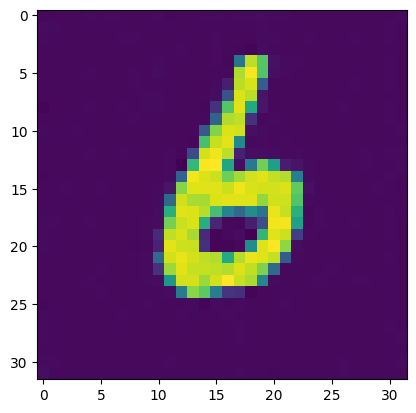

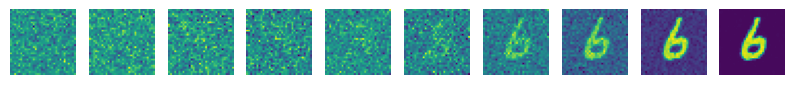

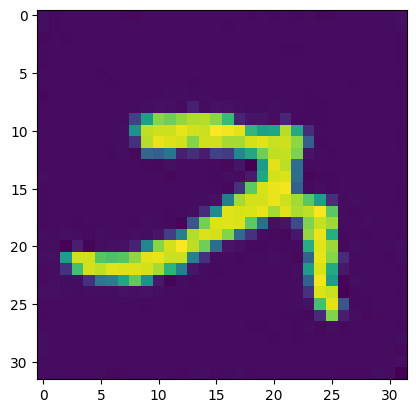

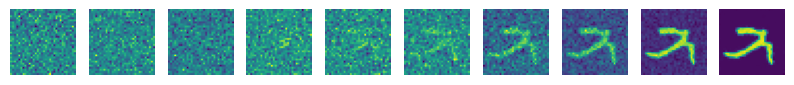

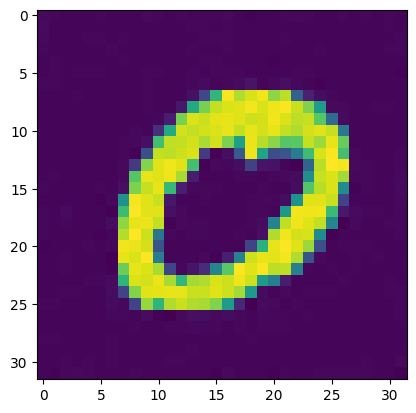

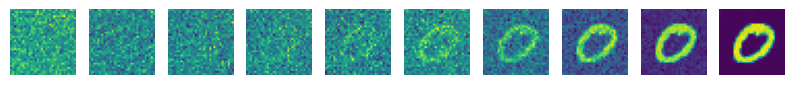

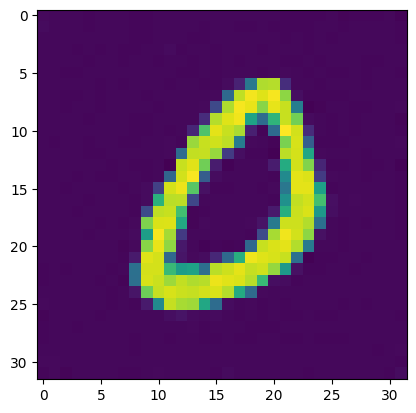

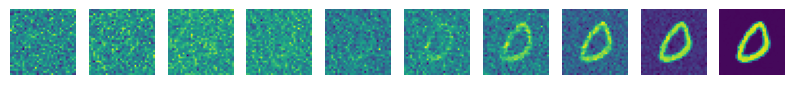

In [11]:
import os
def main():
    checkpoint_file = 'checkpoints/ddpm_checkpoint.pt'
    os.makedirs('checkpoints', exist_ok=True)
    
    # Pass the full checkpoint file path
    # train(checkpoint_path='checkpoints', lr=2e-5, num_epochs=75)
    inference(checkpoint_path=checkpoint_file)  # Use the checkpoint_file variable

if __name__ == '__main__':
    main()